In [2]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import ast
import torch
import torchvision
import cv2
from torchvision import transforms, datasets
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

%matplotlib inline

In [3]:
# Modify Pytorch dataset class for object detection 

class BulbDataset(Dataset):

    '''
    Pytorch Dataset Class updated for bulb project
    Methods created to return image and labels.
    '''
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        '''
        inputs - dataframe: provides data for boxes and labels ['top'	'left'	'height'	'width'	'value'	'External ID'	'value_id']
        image_dir - location where images are saved
        transforms - required transforms for images.    
        '''
        self.image_ids = dataframe['External ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):

        '''
        inputs
        index: index of image to be returned
        outputs
        image
        targets - dictionary of boxes, labels and area
        '''
        
        image_id = self.image_ids[index]
        records = self.df[self.df['External ID'] ==image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        # Box coordinates
        boxes = records[['left', 'top','width', 'height']].values
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # convert to corners of box
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        
        labels = records['value_id'].values
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area']= area
        
        if self.transforms:
            sample = {
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0).float()
            target['labels'] = torch.from_numpy(labels).long()

        return image, target
        
    def __len__(self):
        return self.image_ids.shape[0]
        


In [15]:
# Albumentations library for transfors.
def get_transforms():
    '''
    Uses the albulmentations library to transform images.
    Same transforms used for train and test
    Only uses resize.
    '''
    return A.Compose([
        A.Resize(200, 300),
        ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields': ['labels']})

In [5]:
# Create instance of custom dataset. 
mybulbloader = BulbDataset(df, IMAGE_DIR, get_transforms())

NameError: name 'df' is not defined

In [6]:
# Pytorch pretrained faster RCNN with ResNet50 backbone. 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Correct the head of the model for our domain 
# Retain most of the model as previously trained.
num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/andrew/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


In [94]:
import os

In [96]:
os.mkdir('./image_classifier/weights')

FileNotFoundError: [Errno 2] No such file or directory: './image_classifier/weights'

In [91]:
import wget
# Define the remote file to retrieve
remote_url = "https://github.com/AndrewWalker251/lightbulb_app/releases/download/v0.0.1/model_weights_4.pth"
# Define the local filename to save data
local_file = 'weights.pth'
# Make http request for remote file data
wget.download(remote_url, local_file)

'weights.pth'

In [7]:
PATH = './weights/model_weights_4.pth'

In [8]:
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [85]:
image = cv2.imread(f'test_bulb.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /=255.0
sample = {
    'image':image,
    'bboxes':[],
    'labels':[]
}
transforms = get_transforms()
sample = transforms(**sample)
image = sample['image']

In [87]:
image

tensor([[[0.6605, 0.6536, 0.6514,  ..., 0.4624, 0.4718, 0.4554],
         [0.6441, 0.6537, 0.6351,  ..., 0.4499, 0.4778, 0.4725],
         [0.6607, 0.6568, 0.6343,  ..., 0.4215, 0.4620, 0.4459],
         ...,
         [0.5971, 0.5583, 0.5824,  ..., 0.4879, 0.4707, 0.5230],
         [0.5799, 0.5612, 0.5699,  ..., 0.5105, 0.5070, 0.4925],
         [0.5705, 0.5608, 0.5516,  ..., 0.4848, 0.4649, 0.4885]],

        [[0.6958, 0.6901, 0.6789,  ..., 0.3173, 0.3267, 0.3103],
         [0.6794, 0.6890, 0.6704,  ..., 0.3048, 0.3327, 0.3274],
         [0.6881, 0.6842, 0.6696,  ..., 0.2882, 0.3169, 0.3008],
         ...,
         [0.5304, 0.4995, 0.5235,  ..., 0.4958, 0.4864, 0.5426],
         [0.5132, 0.4946, 0.5032,  ..., 0.5184, 0.5266, 0.5082],
         [0.5117, 0.5020, 0.4849,  ..., 0.5005, 0.4806, 0.5031]],

        [[0.7233, 0.7169, 0.7103,  ..., 0.0507, 0.0522, 0.0318],
         [0.7068, 0.7086, 0.6900,  ..., 0.0381, 0.0582, 0.0529],
         [0.7116, 0.7078, 0.6962,  ..., 0.0097, 0.0384, 0.

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
classes = {'b22':1, 'gu10':2, 'e27':3}
model.eval()
outputs = model([image])
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
for key, value in classes.items(): 
     if value == outputs[0]['labels'].cpu().numpy()[0]: 
            class_label =  key 
print(class_label)
prob = outputs[0]['scores'].cpu().detach().numpy()[0]
print(prob)

tensor([1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 3, 1, 3, 1, 1, 3, 3, 2,
        1, 2, 1, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 1, 2, 3, 1, 3, 1, 1,
        1, 2, 3, 1, 2, 3, 1, 1, 2, 2, 3, 1, 3, 2, 2, 3, 1, 1, 2, 3, 1, 1, 2, 3,
        2, 3, 2, 3, 3, 2, 1, 2, 2, 3, 1, 3, 2, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 3,
        3, 3])

In [76]:
with torch.no_grad():
    pred = model([image])

In [77]:
pred

[{'boxes': tensor([[ 86.9331,  61.7737, 177.5433, 107.6499],
          [ 90.9163,  65.8777, 166.7884,  91.4304],
          [ 76.8216,  60.2615, 167.4459, 100.7888],
          [162.8842,  89.2531, 202.1179, 110.2950],
          [163.3553,  89.5416, 201.5627, 111.4582],
          [110.2920,  55.6389, 181.9775, 106.8232],
          [ 93.0420,  66.3491, 174.6303, 117.6338],
          [104.9418,  62.2779, 154.0474,  95.8289],
          [103.3476,  49.5471, 200.8525, 124.8419],
          [171.1971,  92.2897, 195.5822, 108.8190],
          [ 85.2553,  61.5210, 179.7681, 106.1553],
          [ 86.1183,  82.5811, 181.1175, 116.1939],
          [119.5377,  97.2948, 187.0846, 113.4840],
          [ 72.1637,  52.0494, 151.0649, 112.0280],
          [170.5608,  91.8380, 194.8867, 108.7463],
          [ 97.5609,  52.5500, 159.2918,  95.6520],
          [118.5809,  97.2902, 188.7947, 113.6981],
          [ 87.7329,  49.2774, 178.7493,  88.6116],
          [ 88.0570,  48.1180, 180.8737,  88.5797],
   

In [73]:
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01]

In [49]:
def plot_bulb_and_box_eval(img, objects):
    '''
    Plot image with actual and predicted boxes. 

    inputs
    img - batch of images
    objects - batch of predictions
    actual - batch of actual targets 
    idx - index of image in batch
    '''

    fig, ax = plt.subplots(1,1,figsize = (8,4))

    box = objects[0]['boxes'].cpu().detach().numpy().astype(np.int32)

    xmin = box[0][0]
    ymin = box[0][1]
    xmax = box[0][2]
    ymax = box[0][3]

    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))

    for key, value in classes.items(): 
         if value == objects[0]['labels'].cpu().numpy()[0]: 
                class_label =  key + 'predicted'

    ax.text(xmin, ymin, class_label,color='red', fontsize=16)


    image = img.permute(1,2,0).cpu().numpy()
    

    ax.imshow(image)
    plt.show()


In [50]:
classes = {'b22':1, 'gu10':2, 'e27':3}

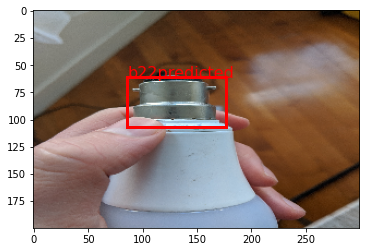

In [52]:
plot_bulb_and_box_eval(image, outputs)

In [12]:
image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1,1,figsize = (8,4))
ax.imshow(image)

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'permute'